In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid', context='talk', palette='bright', color_codes=True)

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize

import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Assigned the date column as index and converted it into datetime format

df = pd.read_csv('tesla-stock-price.csv', index_col=['Date'], parse_dates=['Date'])

In [3]:
df.head(10)

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999,18766300,23.889999
2010-06-30,25.790001,30.420000,23.299999,23.830000,17187100,23.830000
2010-07-01,25.000000,25.920000,20.270000,21.959999,8218800,21.959999
2010-07-02,23.000000,23.100000,18.709999,19.200001,5139800,19.200001
2010-07-06,20.000000,20.000000,15.830000,16.110001,6866900,16.110001
2010-07-07,16.400000,16.629999,14.980000,15.800000,6921700,15.800000
2010-07-08,16.139999,17.520000,15.570000,17.459999,7711400,17.459999
2010-07-09,17.580000,17.900000,16.549999,17.400000,4050600,17.400000
2010-07-12,17.950001,18.070000,17.000000,17.049999,2202500,17.049999


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1692 entries, 2010-06-29 to 2017-03-17
Data columns (total 6 columns):
Open         1692 non-null float64
High         1692 non-null float64
Low          1692 non-null float64
Close        1692 non-null float64
Volume       1692 non-null int64
Adj Close    1692 non-null float64
dtypes: float64(5), int64(1)
memory usage: 92.5 KB


In [5]:
df.describe()

,Open,High,Low,Close,Volume,Adj Close
count,1692.000000,1692.000000,1692.000000,1692.000000,1.692000e+03,1692.000000
mean,132.441572,134.769698,129.996223,132.428658,4.270741e+06,132.428658
std,94.309923,95.694914,92.855227,94.313187,4.295971e+06,94.313187
min,16.139999,16.629999,14.980000,15.800000,1.185000e+05,15.800000
25%,30.000000,30.650000,29.214999,29.884999,1.194350e+06,29.884999
50%,156.334999,162.370002,153.150002,158.160004,3.180700e+06,158.160004
75%,220.557495,224.099999,217.119999,220.022503,5.662100e+06,220.022503
max,287.670013,291.420013,280.399994,286.040009,3.716390e+07,286.040009


In [6]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [7]:
# Dropped unnecessary columns

df = df.drop(['Volume', 'Adj Close'], axis=1)

In [8]:
df.head(10)

,Open,High,Low,Close
Date,,,,
2010-06-29,19.000000,25.000000,17.540001,23.889999
2010-06-30,25.790001,30.420000,23.299999,23.830000
2010-07-01,25.000000,25.920000,20.270000,21.959999
2010-07-02,23.000000,23.100000,18.709999,19.200001
2010-07-06,20.000000,20.000000,15.830000,16.110001
2010-07-07,16.400000,16.629999,14.980000,15.800000
2010-07-08,16.139999,17.520000,15.570000,17.459999
2010-07-09,17.580000,17.900000,16.549999,17.400000
2010-07-12,17.950001,18.070000,17.000000,17.049999


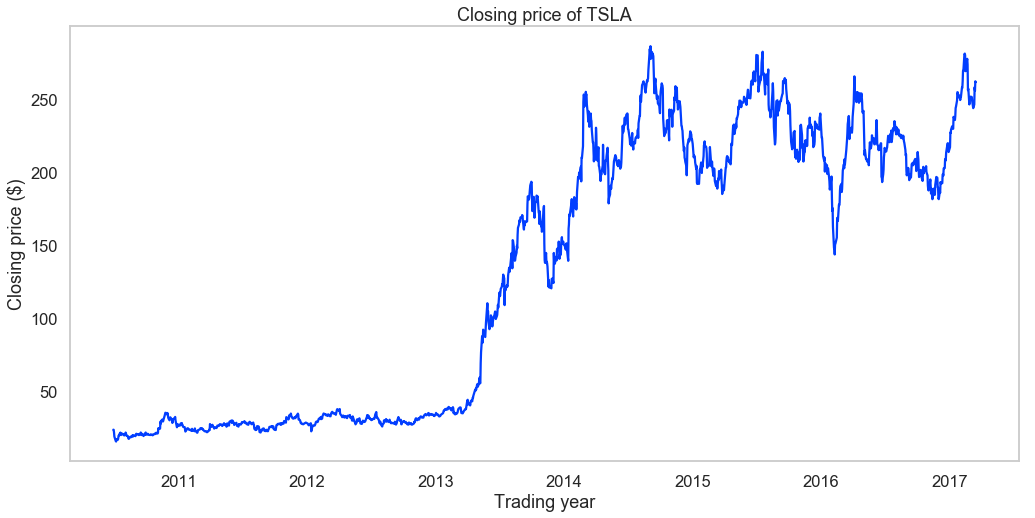

In [9]:
# Visualized the closing price through years

plt.figure(figsize=(17, 8))
plt.plot(df['Close'])
plt.title('Closing price of TSLA')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading year')
plt.grid(False)
plt.show()

In [10]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
        
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

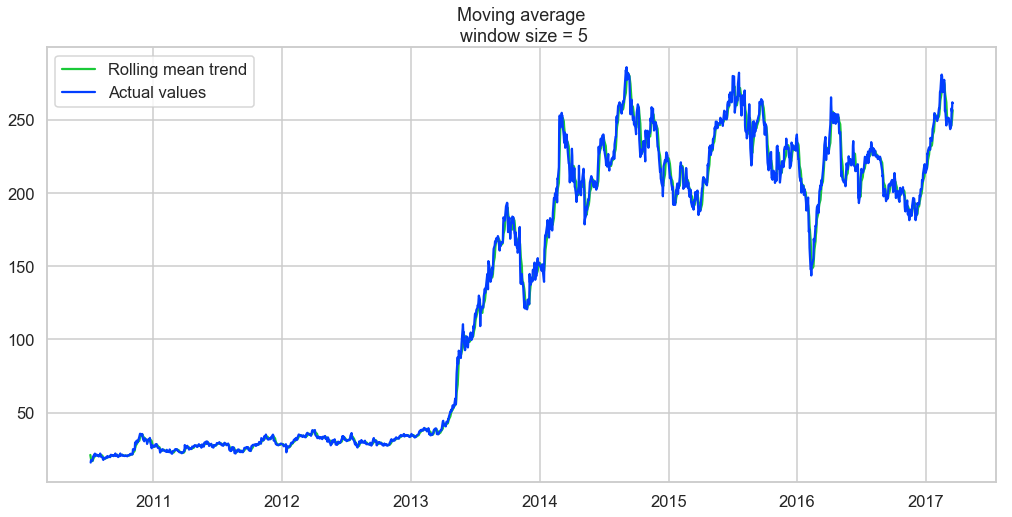

In [11]:
plot_moving_average(df['Close'], 5)

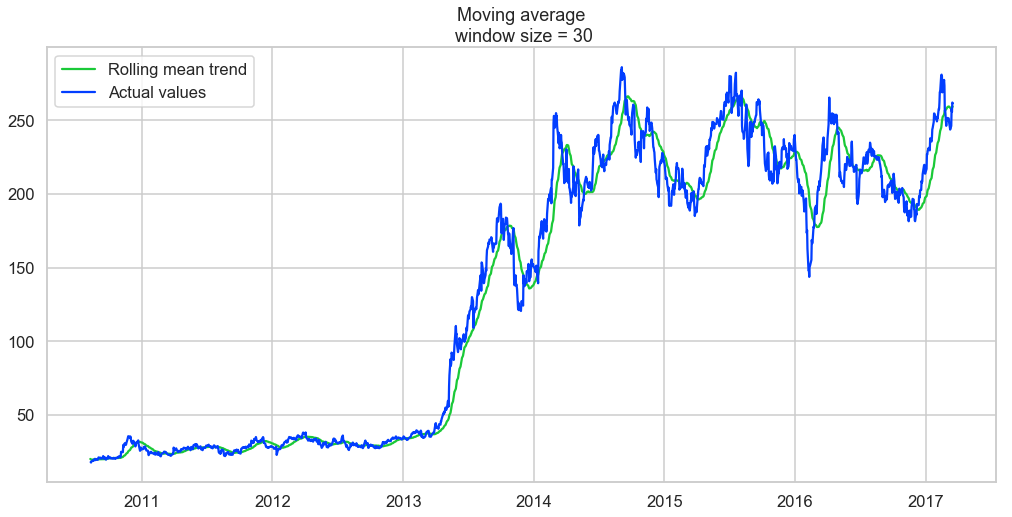

In [12]:
plot_moving_average(df['Close'], 30)

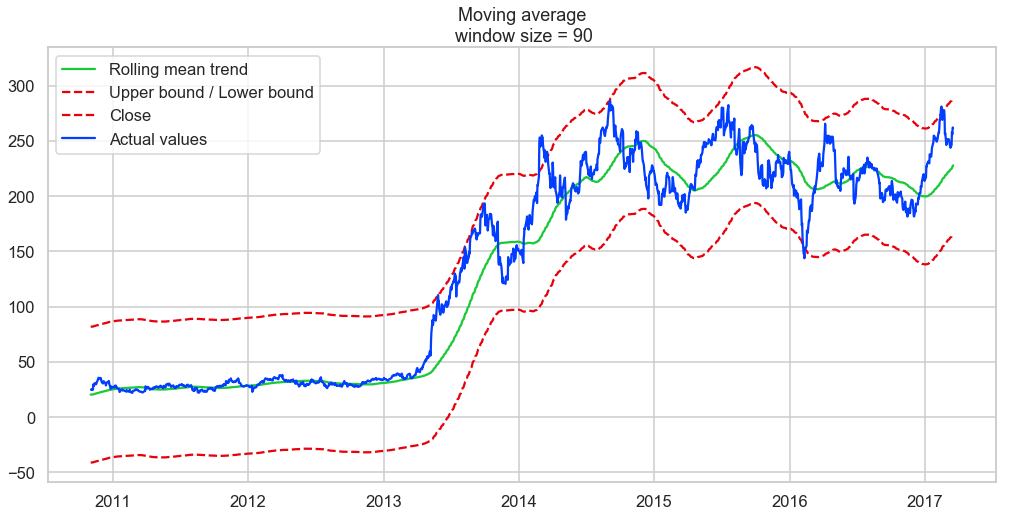

In [13]:
plot_moving_average(df['Close'], 90, plot_intervals=True)

In [14]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha*series[n] + (1-alpha)*result[n-1])
    return result

In [15]:
def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

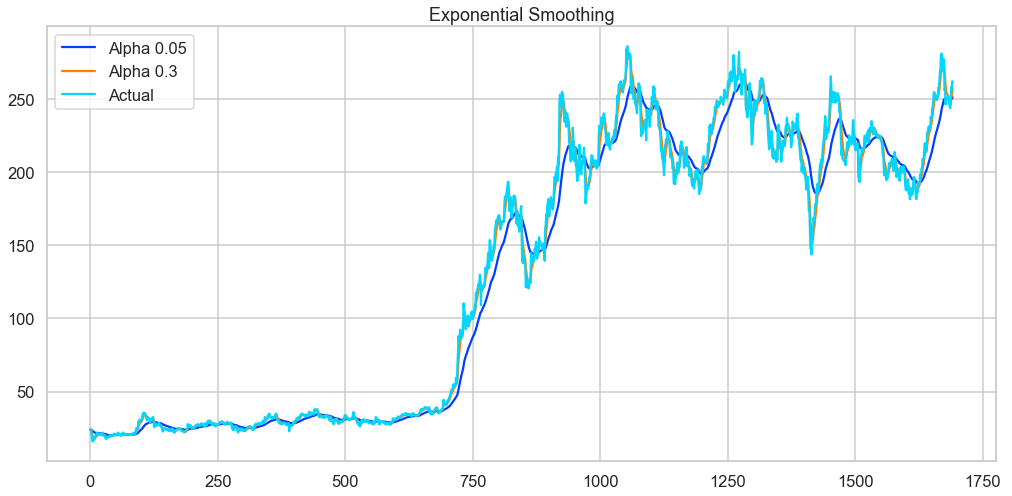

In [16]:
plot_exponential_smoothing(df['Close'], [0.05, 0.3])

In [17]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [18]:
def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

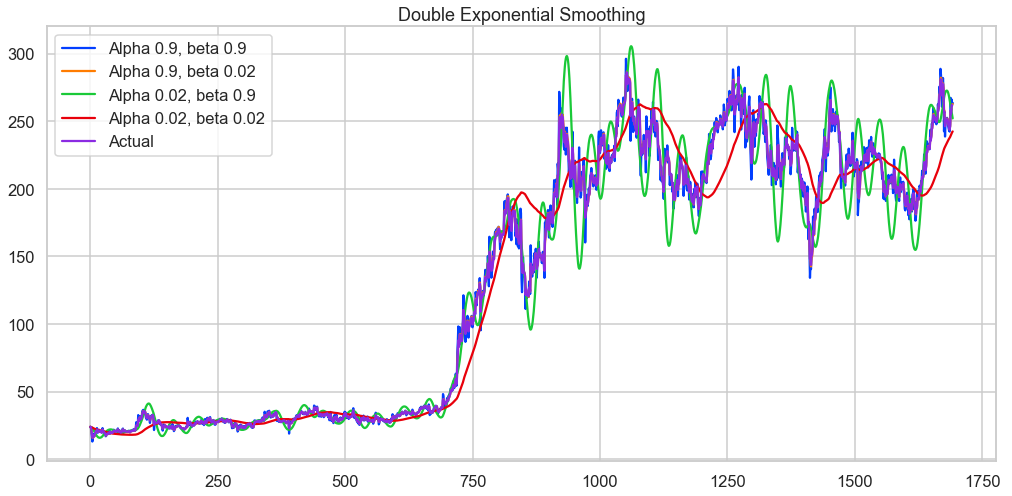

In [19]:
plot_double_exponential_smoothing(df['Close'], alphas=[0.9, 0.02], betas=[0.9, 0.02])